In [1]:
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, AveragePooling2D, Dropout, Flatten, Input, MaxPooling2D, Conv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1,l2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

#vediamo se funzione. Se va riscrivi tutto con dataset

dataset = r"/home/tesi/scala95/Downloads/chest_xray/chest_xray"
#dataset = r"/home/tesi/scala95/Downloads/Skin Cancer/data"

# set the initial learning rate, epochs, batch size

INIT_LR = 1e-02
Batch = 20 #8

#transform the dataset into a dictionary

args={}
args["dataset"] = dataset

args



{'dataset': '/home/tesi/scala95/Downloads/chest_xray/chest_xray'}

In [2]:
#extract the data and store it in "image" and "labels"

import numpy as np
import cv2
import os
from imutils import paths

In [3]:
iPaths = list(paths.list_images(args["dataset"]))

data = []

labels = []

#extract images and labels and convert images to RGB
for iPath in iPaths:
  #labels have all the labels linked to the image; we just need "pneumonia" or "normal" (that is the second-last information in the list (hence -2))
  label = iPath.split(os.path.sep)[-2]
  image = cv2.imread(iPath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #aggiungo resize solo alle training images per motivi didattici, sarebbe da applicare anche agli altri due cicli for
  image = cv2.resize(image, (224, 224))
  #insert in the data list all the images reshaped in 224-224 format and their labels
  data.append(image)
  labels.append(label)

In [4]:
#let's normalize the data (make them have values between 0 and 1) to have a faster model
# remember that RGB images have imputs ranging between 0 (black) and 255 (white) 
data = np.array(data)/255
#also for better fitting in the model, let's also transform the labels in array
labels = np.array(labels)

data.shape

(5856, 224, 224, 3)

In [5]:
#leggiamo le labels, che sotto array vengono etichettate come (0,1) o (1,0) in caso che siano lastre di polmonite o normali, con le loro etichette originali

LB = LabelBinarizer()

# transofrm labels in binary values with 1=pneumonia 0=normal
labels = LB.fit_transform(labels)
labels = to_categorical(labels) #convert number in categorical values ("normal", "pneumonia")

In [6]:
#labels

In [7]:
#split data in training and testing

#random_state è? settato in un numero qualsiasi diverso da 0 per permettere lo shuffle del valori
#stratify si assicura che la percentuale di casi"nurmal" e "pneumonia" siano nella stessa proposzione in train ed in test
(X_train, X_test, y_train, y_test)= train_test_split(data, labels, test_size=0.2, stratify=labels, shuffle=True)

In [8]:
#X_train.shape, X_test.shape, y_test.shape, y_train.shape

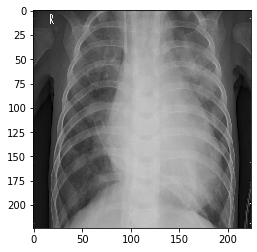

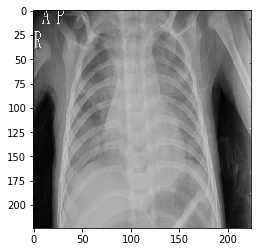

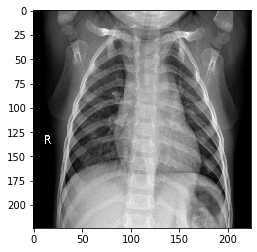

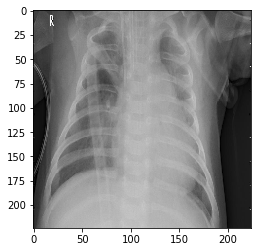

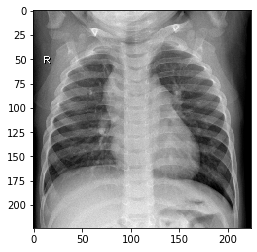

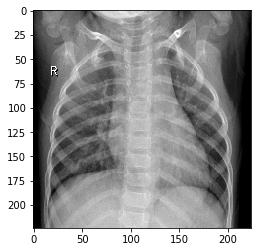

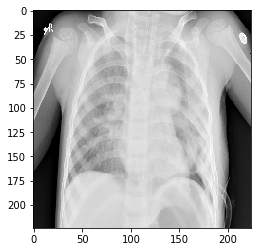

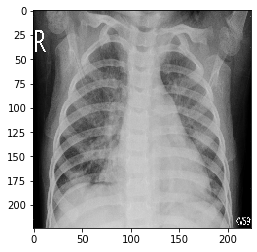

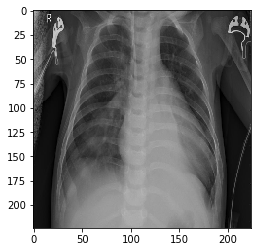

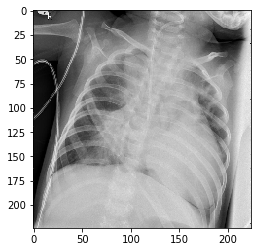

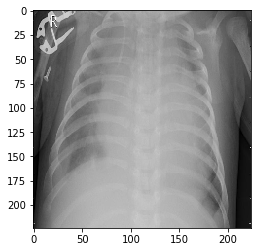

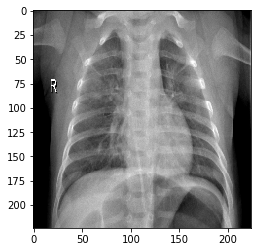

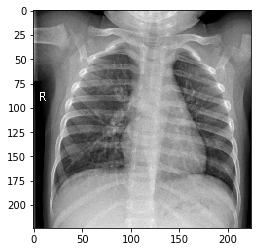

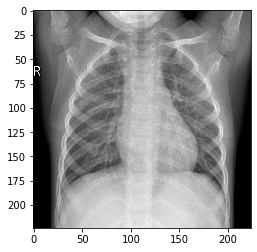

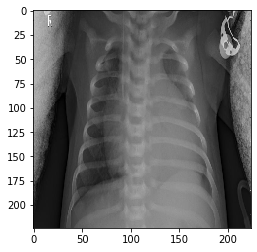

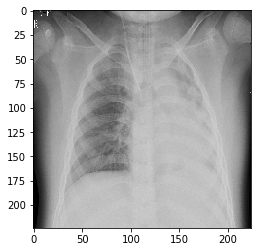

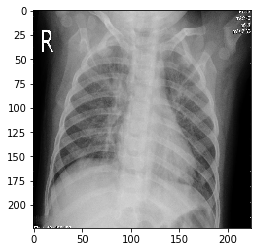

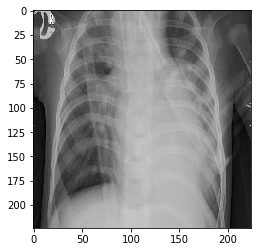

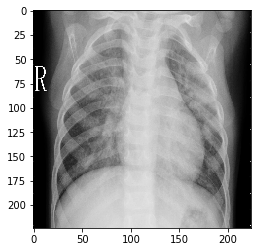

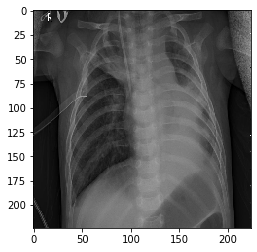

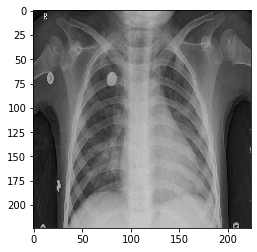

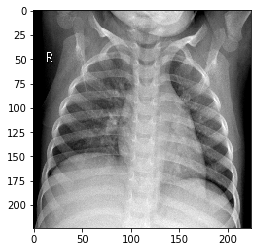

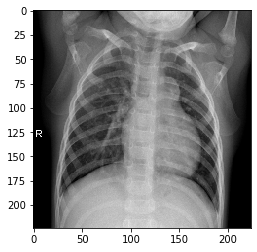

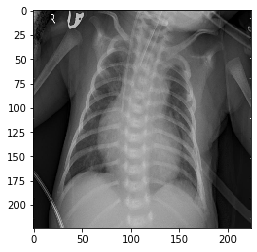

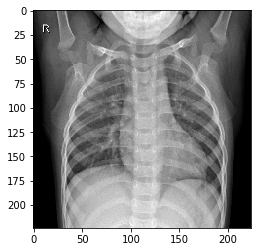

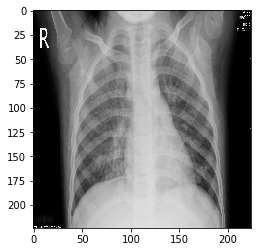

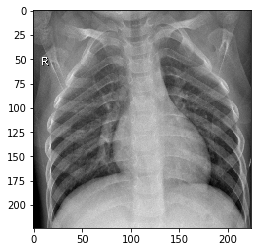

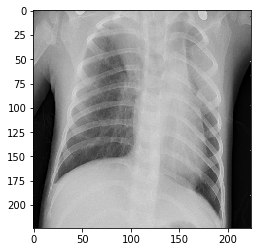

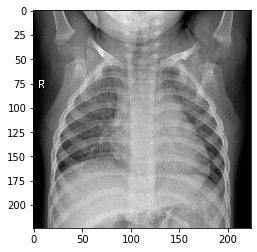

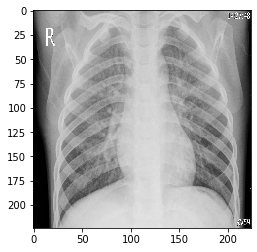

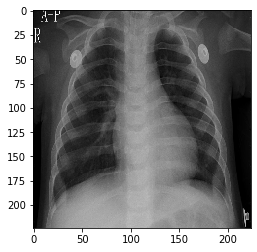

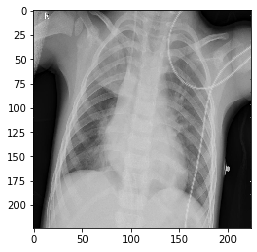

In [9]:
for i in range (0,32):
    image = X_train[i]
    plt.imshow(image)
    plt.show()

In [10]:
from imgaug import augmenters as iaa

In [11]:
seq = iaa.Sequential([
    iaa.Crop(px=(0, 46)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8))]) # blur images with a sigma of 0 to 3.0


In [12]:
images = X_train

X_train_aug = seq(images=images)

X_train_aug.shape

(4684, 224, 224, 3)

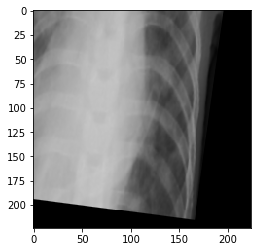

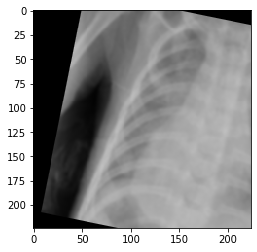

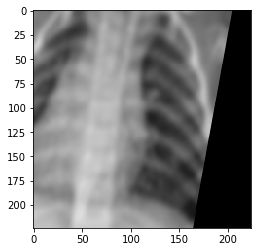

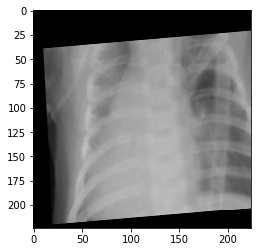

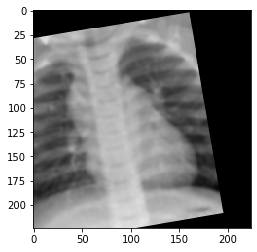

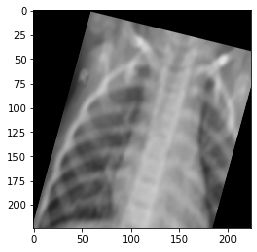

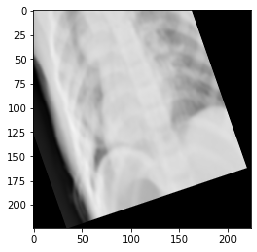

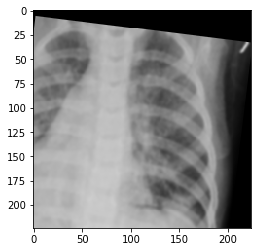

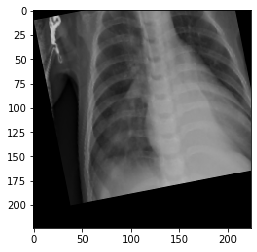

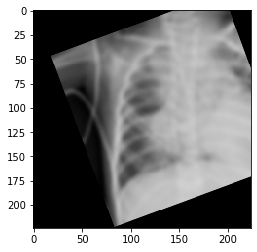

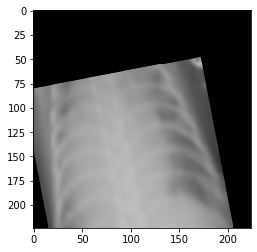

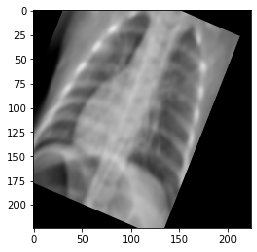

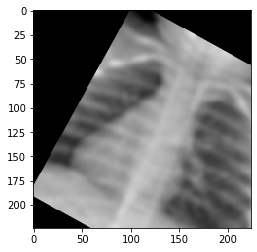

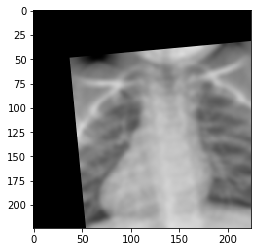

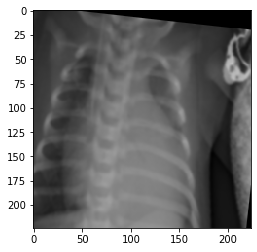

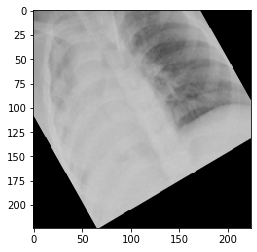

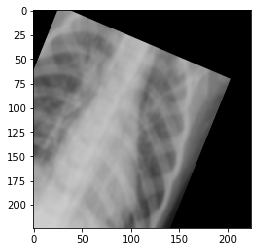

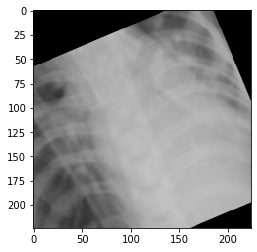

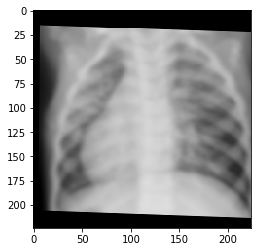

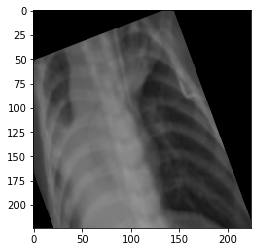

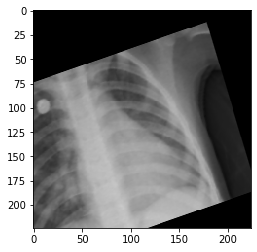

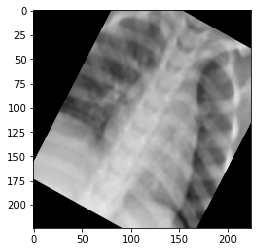

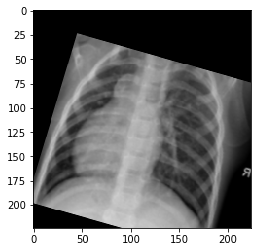

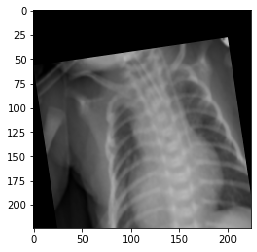

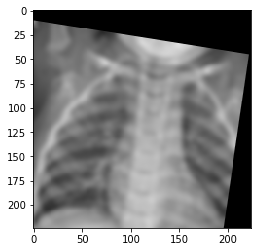

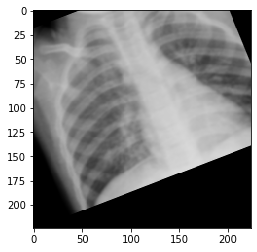

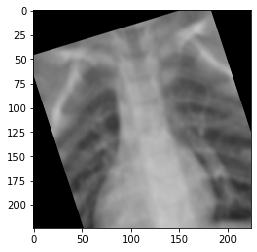

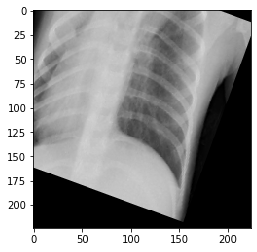

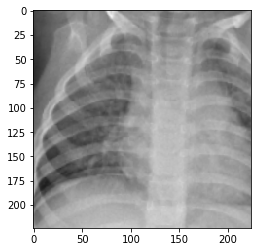

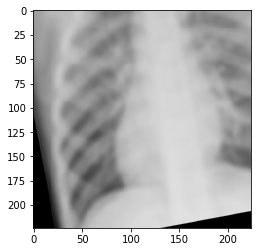

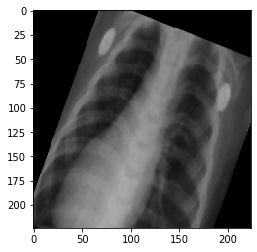

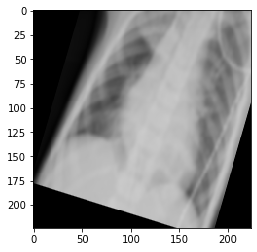

In [13]:
#see results

for i in range (0,32):
    image = X_train_aug[i]
    plt.imshow(image)
    plt.show()

In [14]:
#let's recall the base model, that is the pre-trained model
# do not include the top layer (the last part of the pre-trained neural network) since you have to modify it goy your dataset
#bmodel = InceptionV3(weights="imagenet", include_top = False, input_tensor=Input(shape=(224,224,3)))

#bmodel.summary()

In [15]:
# creation of the architecture

from keras.models import Sequential

model = Sequential()

In [16]:
from tensorflow.keras.applications import DenseNet121, InceptionResNetV2, NASNetLarge, ResNet101V2

cmodel = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#dmodel = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#emodel = NASNetLarge(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#fmodel = ResNet101V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


#model.add(cmodel)
#model.add(Flatten())
#model.add(Dense(1024, activation="relu", kernel_regularizer=l2(0.001))) #regularizer nuovo
#model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001))) #layer nuovo
#model.add(Dropout(0.5))
#model.add(Dense(2, activation="softmax"))

hModel = cmodel.output #head_Model
hModel = Flatten(name="flatten")(hModel)
hModel = Dense(1024, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(512, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(2, activation="softmax")(hModel)
model = Model(inputs=cmodel.input, outputs=hModel)

for layer in cmodel.layers:
  layer.trainable =  False

#the pre-trained model will work as a feature extractor





In [ ]:
#model.summary()

In [17]:
from keras import optimizers

#opt = optimizers.SGD(learning_rate=INIT_LR, momentum=0.9, nesterov=True)

opt = optimizers.Nadam(learning_rate=0.0001)


In [18]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [19]:
from keras.callbacks import EarlyStopping

EarlyStopping = EarlyStopping(monitor= "val_accuracy",min_delta=0.01, patience=10) #5

Epoch 1/50
234/234 [==============================] - 302s 1s/step - loss: 0.8786 - accuracy: 0.7647 - val_loss: 0.5391 - val_accuracy: 0.7845
Epoch 2/50
234/234 [==============================] - 299s 1s/step - loss: 0.4026 - accuracy: 0.8441 - val_loss: 0.2372 - val_accuracy: 0.9052
Epoch 3/50
234/234 [==============================] - 299s 1s/step - loss: 0.3145 - accuracy: 0.8716 - val_loss: 0.3010 - val_accuracy: 0.8672
Epoch 4/50
234/234 [==============================] - 299s 1s/step - loss: 0.2717 - accuracy: 0.8825 - val_loss: 0.3604 - val_accuracy: 0.8517
Epoch 5/50
234/234 [==============================] - 302s 1s/step - loss: 0.2439 - accuracy: 0.9018 - val_loss: 0.2371 - val_accuracy: 0.9052
Epoch 6/50
234/234 [==============================] - 298s 1s/step - loss: 0.2185 - accuracy: 0.9153 - val_loss: 0.2808 - val_accuracy: 0.8897
Epoch 7/50
234/234 [==============================] - 298s 1s/step - loss: 0.2091 - accuracy: 0.9162 - val_loss: 0.2770 - val_accuracy: 0.8879

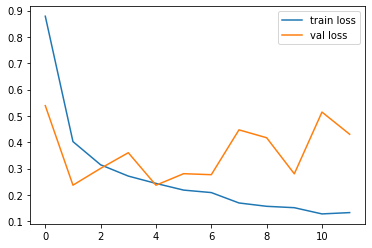

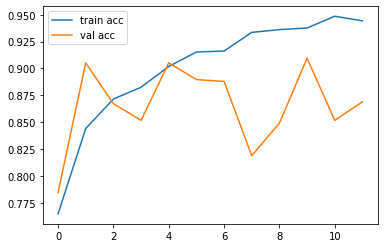

<Figure size 432x288 with 0 Axes>

In [20]:
# use time function to check how much is required to train the model


from time import time



start_time = time()

R = model.fit(
    X_train_aug, y_train, batch_size=Batch,
    steps_per_epoch=len(X_train) // Batch,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // Batch,
    epochs=50, callbacks=[EarlyStopping])

final_time = time() - start_time

print("training time: %d minutes and %d seconds" % (final_time / 60, final_time % 60))

from sklearn.metrics import classification_report


y_pred = model.predict(X_test, batch_size=Batch)
y_pred = np.argmax(y_pred, axis=1)

# confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# accuracy

# plot the loss
plt.plot(R.history['loss'], label='train loss')
plt.plot(R.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('Validation_loss')
# plot the accuracy
plt.plot(R.history['accuracy'], label='train acc')
plt.plot(R.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Validation_accuracy')

In [22]:
#evaluate the model
model.evaluate(X_test, y_test)

21/21 [==============================] - 41s 2s/step - loss: 2.0090 - accuracy: 0.8015


[2.0090410709381104, 0.8015151619911194]

In [21]:
from keras.models import load_model
model.save('Pneumonia_Densenet_Frontend.h5')

Architettura NVIDIA

In [ ]:
model.add(BatchNormalization())
model.add(Conv2D(24 , (5,5) , strides = 2 , padding = 'same' , activation = 'relu', input_shape = (150,150,1)))
model.add(Conv2D(36 , (5,5) , strides = 2 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.4))
model.add(Conv2D(48 , (5,5) , strides = 2 , padding = 'same' , activation = 'relu'))
model.add(Conv2D(36 , (3,3) ,  padding = 'same' , activation = 'relu'))
model.add(Dropout(0.4))
model.add(Conv2D(36 , (3,3) ,  padding = 'same' , activation = 'relu'))
model.add(Flatten())
model.add(Dense(units = 1164 , activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(units = 100 , activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 2 , activation = "sigmoid"))

In [ ]:
#print some results

L = 6
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=Batch)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], y_test.argmax(axis=1)[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1, hspace=1)

In [ ]:
from keras.models import load_model

model.save('Pneumonia_InceptionV3.h5')